# Predicting HDB Resale prices

In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch

In [2]:
import numpy as np
import pandas as pd

import requests

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

df = pd.DataFrame()

rids = ['1b702208-44bf-4829-b620-4615ee19b57c', '83b2fc37-ce8c-4df4-968b-370fd818138b', '8c00bf08-9124-479e-aeca-7cc411d884c4', 'adbbddd3-30e2-445f-a123-29bee150a6fe']
url = 'https://data.gov.sg/api/action/datastore_search'

for rid in rids[0:1]:
  print('Downloading from rid {}'.format(rid))
  params = params={
      'resource_id': rid, 
       'limit': 500000,
  }

  with requests.get(url, params=params) as r:
    df = pd.concat([df,pd.DataFrame(r.json()['result']['records'])])  
    type_dict = ({field['id']: field['type'] for field in r.json()['result']['fields']})

In [0]:
# Setting column dtype
for col in ('floor_area_sqm', 'remaining_lease', 'resale_price'):
    df[col] = pd.to_numeric(df[col])
df['lease_commence_date'] = pd.to_datetime(df['lease_commence_date']).dt.floor('d')
df['month'] = pd.to_datetime(df['month']).dt.floor('d')
df.drop(columns='_id', inplace=True, errors='ignore')

In [0]:
df.flat_type = df.flat_type.astype(
    pd.api.types.CategoricalDtype(
       categories=df.flat_type.unique()[[5, 3, 0, 1, 2, 4, 6]], 
       ordered= True))
# Can we find a way to do this more nicely?

In [0]:
df.storey_range = df.storey_range.astype(
    pd.api.types.CategoricalDtype(
        categories=df.storey_range.unique()[[1,4,0,3,2,6,5,7,8,9,12,10,13,15,14,11,16]], 
        ordered= True))

In [0]:
for col, __ in df.select_dtypes('object').iteritems():
  df[col] = df[col].astype('category')

In [7]:
df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59809 entries, 0 to 59808
Data columns (total 11 columns):
block                  59809 non-null category
flat_model             59809 non-null category
flat_type              59809 non-null category
floor_area_sqm         59809 non-null float64
lease_commence_date    59809 non-null datetime64[ns]
month                  59809 non-null datetime64[ns]
remaining_lease        59809 non-null int64
resale_price           59809 non-null float64
storey_range           59809 non-null category
street_name            59809 non-null category
town                   59809 non-null category
dtypes: category(6), datetime64[ns](2), float64(2), int64(1)
memory usage: 2.9 MB


,block,flat_model,flat_type,floor_area_sqm,lease_commence_date,month,remaining_lease,resale_price,storey_range,street_name,town
count,59809,59809,59809,59809.000000,59809,59809,59809.000000,5.980900e+04,59809,59809,59809
unique,2186,20,7,NaN,50,38,NaN,NaN,17,524,26
top,2,Model A,4 ROOM,NaN,1985-01-01 00:00:00,2017-11-01 00:00:00,NaN,NaN,04 TO 06,YISHUN RING RD,JURONG WEST
freq,241,18042,24628,NaN,4175,1975,NaN,NaN,14195,984,4668
first,NaN,NaN,NaN,NaN,1966-01-01 00:00:00,2015-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2015-01-01 00:00:00,2018-02-01 00:00:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,97.319194,NaN,NaN,74.017890,4.394339e+05,NaN,NaN,NaN
std,NaN,NaN,NaN,24.166368,NaN,NaN,11.274598,1.415803e+05,NaN,NaN,NaN
min,NaN,NaN,NaN,31.000000,NaN,NaN,47.000000,9.050000e+04,NaN,NaN,NaN
25%,NaN,NaN,NaN,75.000000,NaN,NaN,66.000000,3.400000e+05,NaN,NaN,NaN


In [8]:
df.sample(10)

,block,flat_model,flat_type,floor_area_sqm,lease_commence_date,month,remaining_lease,resale_price,storey_range,street_name,town
3631,317,Model A,4 ROOM,103.0,1993-01-01,2015-03-01,77,386000.0,10 TO 12,WOODLANDS ST 31,WOODLANDS
32097,297B,Premium Apartment,5 ROOM,122.0,2001-01-01,2016-09-01,83,460000.0,10 TO 12,COMPASSVALE ST,SENGKANG
17839,520,Improved,5 ROOM,118.0,1980-01-01,2016-01-01,63,710000.0,25 TO 27,ANG MO KIO AVE 5,ANG MO KIO
57809,249,Model A,4 ROOM,104.0,1993-01-01,2018-01-01,74,328000.0,04 TO 06,CHOA CHU KANG AVE 2,CHOA CHU KANG
1178,328,Apartment,EXECUTIVE,163.0,1994-01-01,2015-01-01,78,628000.0,01 TO 03,WOODLANDS ST 32,WOODLANDS
16128,494B,Improved,5 ROOM,124.0,1993-01-01,2015-11-01,76,510000.0,10 TO 12,TAMPINES AVE 9,TAMPINES
4041,28,Improved,3 ROOM,70.0,1976-01-01,2015-04-01,60,373000.0,07 TO 09,TELOK BLANGAH RISE,BUKIT MERAH
35677,808,Apartment,EXECUTIVE,192.0,1994-01-01,2016-11-01,76,765000.0,04 TO 06,WOODLANDS ST 81,WOODLANDS
53887,137,New Generation,3 ROOM,68.0,1985-01-01,2017-10-01,66,285000.0,04 TO 06,YISHUN RING RD,YISHUN
35047,633,Model A,4 ROOM,104.0,1995-01-01,2016-11-01,77,400000.0,07 TO 09,PASIR RIS DR 3,PASIR RIS


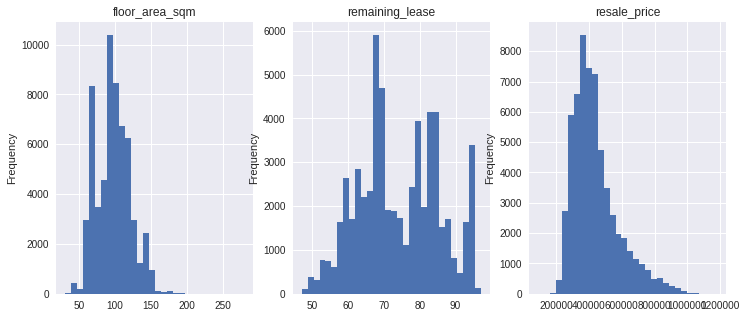

In [9]:
fig, ax = plt.subplots(1,3, figsize=(12,5))
for i, col in enumerate(df.select_dtypes(include=[np.number])):
  df[col].plot.hist(subplots=True, ax=ax[i], bins=30)
  ax[i].set_title(col)

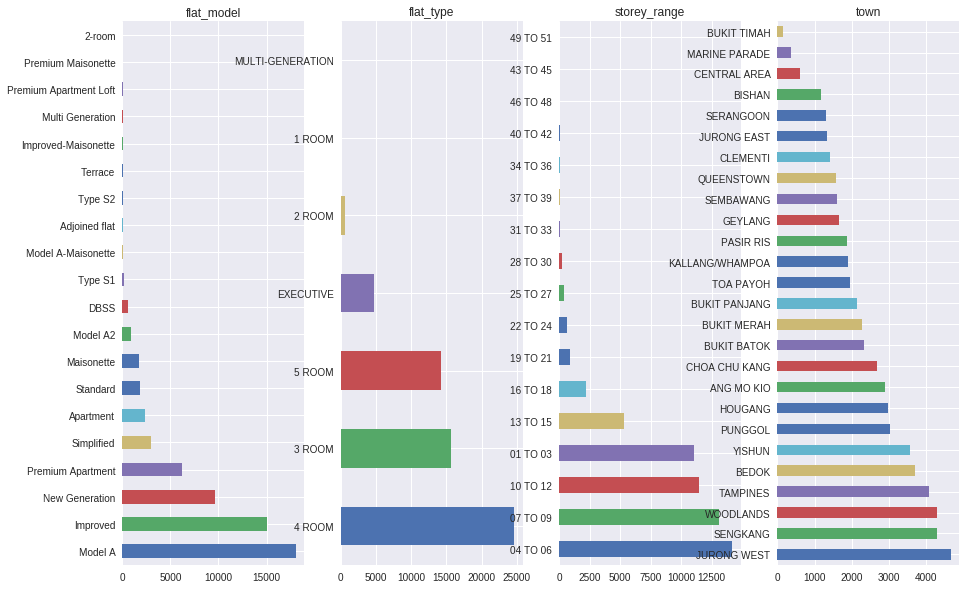

In [10]:
cat_cols = ['flat_model', 'flat_type', 'storey_range', 'town']
fig, ax = plt.subplots(1,len(cat_cols), figsize=(15,10))
for i, col in enumerate(cat_cols):
  if(df[col].nunique() < 30):
    df[col].value_counts().plot.barh(subplots=True, ax=ax[i])

Data looks pretty unbalanced for cetain categorical values.

In [0]:
# from sklearn import linear_model,model_selection
# X_train, X_test, y_train, y_test = model_selection.train_test_split(
#     df.drop(columns='resale_price'), df.resale_price, test_size=0., random_state=42)

In [0]:
# lr=linear_model.LinearRegression()
# lr.fit(X_train, y_train)

Unable to fit with sklearn's model as we have yet to encode text/categorical varaibles into numbers either using LabelEncoder/OneHotEncoding.

In [13]:
df.describe(include='category')

,block,flat_model,flat_type,storey_range,street_name,town
count,59809,59809,59809,59809,59809,59809
unique,2186,20,7,17,524,26
top,2,Model A,4 ROOM,04 TO 06,YISHUN RING RD,JURONG WEST
freq,241,18042,24628,14195,984,4668


It would be best to write a udf to handle category variables. We should differentiate between nominal and ordinal variables. 
For ordinal variables, we would encode the values with its sequence relationship preserved using pandas's category. (I believe we should rely as much as we can on pandas instead of SKlearn)  

For Nominal varaibles, we will first use onehot encoding.
In addition, the udf should have a minimum number of levels parameter to which we should consider utilising dimension reduction techniques.  
It would be ideal if the UDF could handle multiple dimension reduction techniques.
Candidate techniques in order of increasing complexity includes:  

1.   Feature Hashing  
```
  from sklearn.feature_extraction import FeatureHasher
  X_train_hash = copy.copy(X_train)
  X_test_hash = copy.copy(X_test)
  for i in range(X_train_hash.shape[1]):
      X_train_hash.iloc[:,i]=X_train_hash.iloc[:,i].astype('str')
  for i in range(X_test_hash.shape[1]):
      X_test_hash.iloc[:,i]=X_test_hash.iloc[:,i].astype('str')
  h = FeatureHasher(n_features=100,input_type="string")
  X_train_hash = h.transform(X_train_hash.values)
  X_test_hash = h.transform(X_test_hash.values)
```
2.  Count Encoding
```
  X_train_ctr = copy.copy(X_train)
  X_test_ctr = copy.copy(X_test)
  X_train_ctr["test"]=0
  X_test_ctr["test"]=1
  temp_df = pandas.concat([X_train_ctr,X_test_ctr],axis=0)
  for i in range(temp_df.shape[1]):
      temp_df.iloc[:,i]=temp_df.iloc[:,i].astype('category')
  X_train_ctr=temp_df[temp_df["test"]==0].iloc[:,:-1]
  X_test_ctr=temp_df[temp_df["test"]==1].iloc[:,:-1]
  temp_df = pandas.concat([X_train_ctr,y_train],axis=1)
  names = list(X_train_ctr.columns.values)
  for i in names:
      means = temp_df.groupby(i)['click'].mean()
      means = means.fillna(sum(temp_df['click'])/len(temp_df['click']))
      means += np.random.rand(len(means))/1000
      X_train_ctr[i].cat.categories = means
      X_test_ctr[i].cat.categories = means
```
3.  Cat2Vec
```
  from gensim.models.word2vec import Word2Vec
  from random import shuffle
  size=6
  window=8
  x_w2v = copy.deepcopy(data.iloc[:,features])
  names = list(x_w2v.columns.values)
  for i in names:
      x_w2v[i]=x_w2v[i].astype('category')
      x_w2v[i].cat.categories = ["Feature %s %s" % (i,g) for g in x_w2v[i].cat.categories]
  x_w2v = x_w2v.values.tolist()
  for i in x_w2v:
      shuffle(i)
  w2v = Word2Vec(x_w2v,size=size,window=window)
  X_train_w2v = copy.copy(X_train)
  X_test_w2v = copy.copy(X_test)
  for i in names:
      X_train_w2v[i]=X_train_w2v[i].astype('category')
      X_train_w2v[i].cat.categories = ["Feature %s %s" % (i,g) for g in X_train_w2v[i].cat.categories]
  for i in names:
      X_test_w2v[i]=X_test_w2v[i].astype('category')
      X_test_w2v[i].cat.categories = ["Feature %s %s" % (i,g) for g in X_test_w2v[i].cat.categories]
  X_train_w2v = X_train_w2v.values
  X_test_w2v = X_test_w2v.values
  x_w2v_train = np.random.random((len(X_train_w2v),size*X_train_w2v.shape[1]))
  for j in range(X_train_w2v.shape[1]):
      for i in range(X_train_w2v.shape[0]):
          if X_train_w2v[i,j] in w2v:
              x_w2v_train[i,j*size:(j+1)*size] = w2v[X_train_w2v[i,j]]
  x_w2v_test = np.random.random((len(X_test_w2v),size*X_test_w2v.shape[1]))
  for j in range(X_test_w2v.shape[1]):
      for i in range(X_test_w2v.shape[0]):
          if X_test_w2v[i,j] in w2v:
              x_w2v_test[i,j*size:(j+1)*size] = w2v[X_test_w2v[i,j]]
```
4.  Category specific Cat2Vec


In [18]:
### Categorical varaibles embedding UDF###

# Lets just try with a single ordinal variable encoded
#flat_type
#storey_range

def encode_cat(df, columns=[], inplace=True):
  outdf = df.copy(deep=True)
  if len(columns>0):
    for col in columns:
      if df[col].dtype == 'category':
        if df[col].cat.ordered == True: 
          if inplace == True:
            df['%s_enc' % col] = df[i].cat.code
          else:
            outdf['%s_enc' % col] = df[i].cat.codes
      else:
        print('%s is not a category dtype')

df2 = df.copy(deep=True)
df2.info()

# if is_ordered(df.flat_type.cat):
#   for i,j in enumerate(df.flat_type.cat.categories):
#     print("'%s' will be encoded as %s" % (j, i))
#   print(df.flat_type.cat.codes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59809 entries, 0 to 59808
Data columns (total 11 columns):
block                  59809 non-null category
flat_model             59809 non-null category
flat_type              59809 non-null category
floor_area_sqm         59809 non-null float64
lease_commence_date    59809 non-null datetime64[ns]
month                  59809 non-null datetime64[ns]
remaining_lease        59809 non-null int64
resale_price           59809 non-null float64
storey_range           59809 non-null category
street_name            59809 non-null category
town                   59809 non-null category
dtypes: category(6), datetime64[ns](2), float64(2), int64(1)
memory usage: 2.9 MB
